### Bibliotecas

In [1]:
from __future__ import print_function

import numpy as np
from scipy import ndimage
import ipywidgets as wid
import random
from os import path

import matplotlib.pyplot as plt
import matplotlib.style as mplstyle
from matplotlib.pyplot import figure, draw, pause

import bqplot.pyplot as bplt
import bqplot as bq

from IPython.display import Image
from IPython.core.display import HTML, display

import cv2

from ipycanvas import Canvas, hold_canvas
#from skimage.morphology import watershed
#from skimage.feature import peak_local_max
#from sklearn.feature_extraction import image
#from sklearn.cluster import spectral_clustering

In [2]:
# %matplotlib inline
plt.rcParams['figure.figsize']=[30, 20]
plt.rcParams["image.aspect"] = 'equal' 
#plt.gray()
plt.style.use('dark_background')
mplstyle.use('fast')
plt.ion()

In [3]:
%%javascript
document.body.classList.add('theme-dark')

<IPython.core.display.Javascript object>

### Imagens Iniciais

(1200, 1600, 3)
(1200, 1600, 3)


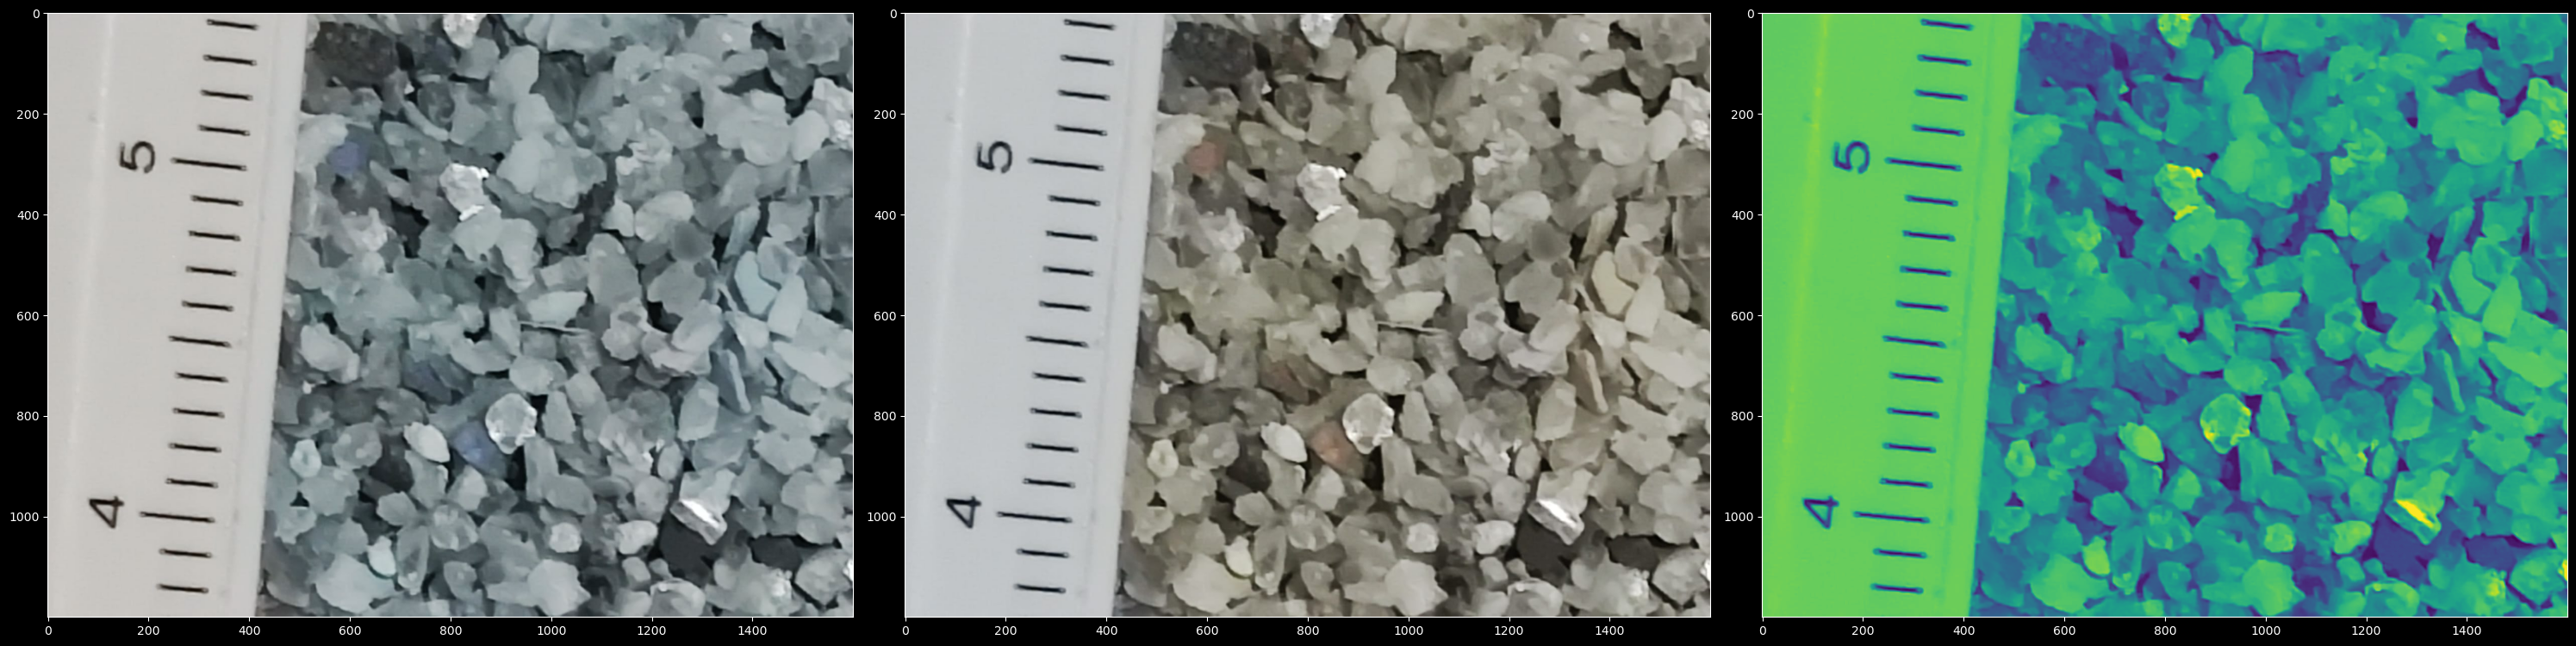

In [4]:
'''image_path = os.path.abspath('./imagens/desmonte.jpg')
file = open("/root/MEGA/Códigos/cvgran/imagens/desmonte.jpg", "rb")
image = file.read()'''

img = cv2.imread('../input/granulometry/gran_1.jpeg',1)
print(img.shape)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img_rgb.shape)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.subplot(131)
plt.imshow(img)
plt.subplot(132)
plt.imshow(img_rgb)
plt.subplot(133)
plt.imshow(img_gray)

### Widgets

In [5]:
out_layout = wid.Layout(display='flex',
                        flex_flow='column',  
                        align_items='stretch')

out_test = wid.Layout(flex_flow ='row wrap', border = '0px solid white', display='flex',
                      min_width='800px', max_width='1000px', 
                      min_height='400px', max_height='800px',
                      align_items='center',justify_content='center',
                      overflow_x='auto', overflow_y='auto'
                     )

ac_layout = wid.Layout(display='flex',
                             flex_flow='column',  
                             align_items='stretch',
                             width='430px')

ac_items_layout = wid.Layout(display='flex',
                             flex_flow='column',  
                             align_items='stretch',
                             width='410px')
#################################################################################################################
header        = wid.HTML(value="<h1>Análise de Imagens</h1>")

data_buttom = wid.FileUpload(accept='*.jpeg *.jpg *.png',
                             multiple=False
                            )
#################################################################################################################
simple_thresh_drop=wid.Dropdown(options=['THRESH_BINARY','THRESH_BINARY_INV','THRESH_TRUNC','THRESH_TOZERO','THRESH_TOZERO_INV'],
                                value='THRESH_BINARY',
                                description='Method',
                                style={'description_width':'44px'},
                                disabled=False
                               )
simple_thresh_slider=wid.IntSlider(value=127, min=0, max=255, step=1, description='Thresh Value:',
                                  layout={'max_width':'440px', 'width':'auto'}
                                  )
simple_items = wid.Box([simple_thresh_drop,
                        simple_thresh_slider ],
                       layout=ac_items_layout
                      )
############################################################################
adapta_thresh_drop=wid.Dropdown(options=['ADAPTIVE_THRESH_MEAN_C', 'ADAPTIVE_THRESH_GAUSSIAN_C'],
                                value='ADAPTIVE_THRESH_MEAN_C',
                                description='Method',
                                style={'description_width':'44px'},
                                disabled=False
                               )
adapta_block_size=wid.IntSlider(value=11, min=3, max=21, step=2, description='Block Size',
                                  layout={'max_width':'440px', 'width':'auto'}
                               )
adapta_block_C=wid.IntSlider(value=7, min=-21, max=21, step=1, description='C',
                                  layout={'max_width':'440px', 'width':'auto'}
                            )
adapta_items = wid.Box([adapta_thresh_drop, 
                        wid.Box([adapta_block_size,
                                 adapta_block_C],
                                layout=ac_items_layout)],
                       layout=ac_items_layout
                      ) 
############################################################################
morpho_drop = wid.Dropdown(options=['Erosion', 'Dilation', 'Opening', 'Closing','Morphological Gradient',
                                   'Top Hat', 'Black Hat'],
                           value='Erosion', description='Operação Morphológica',disabled=False)
morpho_iter_s = wid.IntSlider(min=0, max=10, step=1, description='Iteration Value',
                                  layout={'max_width':'440px', 'width':'auto'})

morpho_items = wid.Box([morpho_drop, morpho_iter_s],
                       layout=ac_items_layout)
############################################################################
ws_op_iter = wid.IntSlider(min=0, max=6, value=2, step=1, description='Opening Iterations Number', layout={'max_width':'440px', 'width':'auto'})
ws_bg_iter = wid.IntSlider(min=0, max=6, value=3, step=1, description='Dilate Iterations Number', layout={'max_width':'440px', 'width':'auto'})
ws_sf_tfactor = wid.FloatSlider(min=0.1, max=0.9, value=0.7, step=0.1, description='Sure Figure Threshold Factor', layout={'max_width':'440px', 'width':'auto'})
ws_sf_tvalue = wid.IntSlider(min=0, max=255, value=1, step=1, description='Sure Figure Threshold Factor', layout={'max_width':'440px', 'width':'auto'})


ws_items = wid.Box([ws_op_iter, ws_bg_iter, ws_sf_tfactor, ws_sf_tvalue],
                   layout=ac_items_layout)
############################################################################
c_t1 = wid.IntSlider(min=0, max=255, value=100, step=1, description='Threshold 1 Value', layout={'max_width':'440px', 'width':'auto'})
c_t2 = wid.IntSlider(min=0, max=255, value=200, step=1, description='Threshold 2 Value', layout={'max_width':'440px', 'width':'auto'})

c_items = wid.Box([c_t1, c_t2], layout=ac_items_layout)
############################################################################
contour_t_value = wid.IntSlider(min=0, max=255, value=127, description='Threshold Value', layout={'max_width':'440px', 'width':'auto'})
#contour_t_type = wid.IntSlider(min=0, max=7, value=0, description='Threshold Type', layout={'max_width':'440px', 'width':'auto'})
im_seg_cont_title  = wid.HTML(value='<h4>Achando Contornos')

im_seg_c_conv  = wid.HTML(value='<h4>Casco Convexo')
im_seg_h_t = wid.IntSlider(min=0, max=255, value=127, description='Threshold Value', 
                           layout={'max_width':'440px', 'width':'auto'})

im_seg_a_elip  = wid.HTML(value='<h4>Ajuste de Elipses')
im_seg_e_t = wid.IntSlider(min=0, max=255, value=127, description='Threshold Value', 
                           layout={'max_width':'440px', 'width':'auto'})

contour_items=wid.Box([im_seg_cont_title,
         contour_t_value,
         im_seg_c_conv,
         im_seg_h_t,
         im_seg_a_elip,
                      im_seg_e_t],
        layout=ac_items_layout)
############################################################################
p_f_title = wid.HTML(value='<h4> Image Filtering')
p_f_ksize = wid.IntSlider(min=3, max=9, step=2)

p_a_title = wid.HTML(value='<h4> Averaging ')
p_a_ksize = wid.IntSlider(min=3, max=9, step=2)

p_g_title = wid.HTML(value='<h4> Filtro Gaussiano ')
p_g_ksize = wid.IntSlider(min=3, max=9, step=2)

p_m_title = wid.HTML(value='<h4> Filtragem Mediana ')
p_m_ksize = wid.IntSlider(min=3, max=9, step=2)

p_b_title = wid.HTML(value='<h4> Filtragem Bilateral ')
p_b_d = wid.IntSlider(min=3, max=9, value=5, step=2)
p_b_s1 = wid.IntSlider(min=5, max=185, step=1)

pre_items = wid.Box([p_f_title, p_f_ksize, 
                     p_a_title,p_a_ksize, 
                     p_g_title,p_g_ksize, 
                     p_m_title, p_m_ksize,
                     p_b_title,p_b_d, p_b_s1],
                       layout=out_layout
                      )
############################################################################
left_accordion = wid.Accordion(children=[pre_items,
                                         morpho_items,
                                         simple_items,
                                         adapta_items,
                                         ws_items,
                                         c_items,
                                         contour_items
                                        ],
                               layout=ac_layout
                              )
left_accordion.set_title(0,'Pré-Processamento')
left_accordion.set_title(1,'Morphological Operations')
left_accordion.set_title(2,'Thresholding Simples')
left_accordion.set_title(3,'Thresholding Adaptivo')
left_accordion.set_title(4,'Watershed')
left_accordion.set_title(5,'Canny Edge Detection')
left_accordion.set_title(6,'Segmentação de Imagens')

#options = wid.Tab(children=[left_accordion], layout =  wid.Layout(display='flex',flex_flow='column',  
 #                                                       align_items='stretch', width='460px')
  #     )
options = left_accordion

In [6]:
out_left = wid.Output()
with out_left:
    display(options)

############################################################################

out_center = wid.Output(layout=out_test)

############################################################################
out_top = wid.Output(layout=wid.Layout(height='120px'))
############################################################################
out_right=wid.Output()

############################################################################
out_bottom = wid.Output()
############################################################################
app = wid.AppLayout(header=out_top,
          left_sidebar=out_left,
          center=out_center,
          right_sidebar=out_right,
          footer=out_bottom)
#################################################################################################################
#fg = figure()
scale=1.0
canvas = Canvas(size=(scale*img.shape[1], scale*img.shape[0]))
canvas.put_image_data(img_gray, 0, 0)

with app.center:
    #display(plt.imshow(img_gray))
    #display(Image(filename='./imagens/desmonte.jpg'))
    display(canvas)
############################################################################
with app.header:
    display(header, data_buttom)
############################################################################   
sv_state_b = wid.Button(description='Salvar Estado', 
                       tooltip='Esta será a Imagem Utilizada nas Próximas Etapas')

sv_img_b = wid.Button(description='Salvar Imagem', 
                          tooltip='Salvar no Arquivo')

ax_options={'x': dict(label='Size (mm)', grid_lines='solid', orientation='horizontal'), 
            'y': dict(label='Porcentagem Passante Acumulada', grid_lines='solid', orientation='vertical', 
                      tick_format='0.2f')}
xs = bq.LinearScale(min=0, max=256)
ys = bq.LinearScale(min=0)

with app.right_sidebar:
    display(wid.HBox([sv_state_b, sv_img_b]))
    
with app.right_sidebar:
    bq_hist_fig = bplt.figure(title='Frequência', title_style={'font-size': '20px'}, 
                              animation_duration=1000, axes_options=ax_options,
                              layout={'height':'550px', 'width':'550px'},
                              fig_margin={'top':0,'bottom':30, 'left':50, 'right':30},
                              scale_x=xs, scale_y=ys
                             )
    hist_data = cv2.calcHist([img_gray],[0],None,[256],[0,256])
    hist = bplt.plot(x=range(0,256), y=hist_data,
                     colors=['white'], fill='bottom', fill_opacities=[0.5], stroke_width=1.0)
    bplt.show()
    #display(bq_hist_fig)
#################################################################################################################
app

AppLayout(children=(Output(layout=Layout(grid_area='header', height='120px')), Output(layout=Layout(grid_area=…

# Preprossessing

In [7]:
def p_f(k_size, img=img_gray):
    kernel = np.ones((k_size,k_size),np.float32)/25
    dst = cv2.filter2D(img,-1,kernel)
    
    with hold_canvas(canvas):
        canvas.clear()
        canvas.put_image_data(dst, 0, 0)
        
    hist.y=cv2.calcHist([dst],[0],None,[256],[0,256])
out_center=wid.interactive_output(p_f, {'k_size':p_f_ksize})

def p_a(k_size, img=img_gray):
    blur = cv2.blur(img,(k_size,k_size))
    
    with hold_canvas(canvas):
        canvas.clear()
        canvas.put_image_data(blur, 0, 0)
        
    hist.y=cv2.calcHist([blur],[0],None,[256],[0,256])
out_center=wid.interactive_output(p_a, {'k_size':p_a_ksize})

def p_g(k_size, img=img_gray):
    blur = cv2.GaussianBlur(img,(k_size,k_size),0)
    
    with hold_canvas(canvas):
        canvas.clear()
        canvas.put_image_data(blur, 0, 0)
        
    hist.y=cv2.calcHist([blur],[0],None,[256],[0,256])
out_center=wid.interactive_output(p_g, {'k_size':p_g_ksize})

def p_m(k_size, img=img_gray):
    median = cv2.medianBlur(img,k_size)
    
    with hold_canvas(canvas):
        canvas.clear()
        canvas.put_image_data(median, 0, 0)
        
    hist.y=cv2.calcHist([median],[0],None,[256],[0,256])
out_center=wid.interactive_output(p_m, {'k_size':p_m_ksize})

def p_b(d, sigma1, img=img_gray):
    blur = cv2.bilateralFilter(img,d,sigma1,sigma1)
    
    with hold_canvas(canvas):
        canvas.clear()
        canvas.put_image_data(blur, 0, 0)
        
    hist.y=cv2.calcHist([blur],[0],None,[256],[0,256])
out_center=wid.interactive_output(p_b, {'d':p_b_d,
                                       'sigma1':p_b_s1})

# Transformações Morfológicas

In [8]:
def morpho(iterate, img=img_gray):
    kernel = np.ones((5,5),np.uint8)
    if morpho_drop.value=='Erosion':
        morpho_img = cv2.erode(img, kernel, iterations=iterate)
    elif morpho_drop.value=='Dilation':
        morpho_img = cv2.dilate(img, kernel, iterations=iterate)
    elif morpho_drop.value=='Opening':
        morpho_img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel, iterations=iterate)
    elif morpho_drop.value=='Closing':
        morpho_img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=iterate)
    elif morpho_drop.value=='Morphological Gradient':
        morpho_img = cv2.morphologyEx(img, cv2.MORPH_GRADIENT, kernel, iterations=iterate)
    elif morpho_drop.value=='Top Hat':
        morpho_img = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, kernel, iterations=iterate)
    elif morpho_drop.value=='Black Hat':
        morpho_img = cv2.morphologyEx(img, cv2.MORPH_BLACKHAT, kernel, iterations=iterate)
    
    with hold_canvas(canvas):
        canvas.clear()
        canvas.put_image_data(morpho_img, 0, 0)
        
    hist.y=cv2.calcHist([morpho_img],[0],None,[256],[0,256])
    
out_center=wid.interactive_output(morpho, {'iterate':morpho_iter_s})

# THRESHOLDING

### Simple Threshold 

In [9]:
#ret,thresh = cv2.threshold(img_gray,simple_thresh_slider.value,255,cv2.THRESH_BINARY)
def simple_thresh(value, img=img_gray):
    if simple_thresh_drop.value == 'THRESH_BINARY':
        ret,thresh = cv2.threshold(img,value,255,cv2.THRESH_BINARY)
    elif simple_thresh_drop.value == 'THRESH_BINARY_INV':
        ret,thresh = cv2.threshold(img,value,255,cv2.THRESH_BINARY_INV)
    elif simple_thresh_drop.value == 'THRESH_TRUNC':
        ret,thresh = cv2.threshold(img,value,255,cv2.THRESH_TRUNC)
    elif simple_thresh_drop.value == 'THRESH_TOZERO':
        ret,thresh = cv2.threshold(img,value,255,cv2.THRESH_TOZERO)
    elif simple_thresh_drop.value == 'THRESH_TOZERO_INV':
        ret,thresh = cv2.threshold(img,value,255,cv2.THRESH_TOZERO_INV)

    with hold_canvas(canvas):
        canvas.clear()
        canvas.put_image_data(thresh, 0, 0)
        
    hist.y=cv2.calcHist([thresh],[0],None,[256],[0,256])
        
out_center=wid.interactive_output(simple_thresh, {'value':simple_thresh_slider})

### Adaptive Threshold 

In [10]:
def adapta_thresh(block_size, C, img=img_gray):
    ret,thresh = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
    if adapta_thresh_drop.value == 'ADAPTIVE_THRESH_MEAN_C':
        thresh = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,block_size,C)
        
    elif simple_thresh_drop.value == 'ADAPTIVE_THRESH_GAUSSIAN_C':
        thresh = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
                                  cv2.THRESH_BINARY,block_size,C)
    
    with hold_canvas(canvas):
        canvas.clear()
        canvas.put_image_data(thresh, 0, 0)
        
    hist.y=cv2.calcHist([thresh],[0],None,[256],[0,256])
    
out_center=wid.interactive_output(adapta_thresh, {'block_size':adapta_block_size,
                                                 'C':adapta_block_C})

### Binarização de Otsu's (Verificar)

### Threshold com algoritmo WATERSHED

In [11]:
def water(op_iter, bg_iter, sf_tfactor, t_value, g_img=img_gray, img=img_rgb):
    #water = cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(g_img,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    # noise removal
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = op_iter)
    # sure background area
    sure_bg = cv2.dilate(opening,kernel,iterations=bg_iter)
    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
    ret, sure_fg = cv2.threshold(dist_transform,sf_tfactor*dist_transform.max(),t_value,0)
    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)
    ###############################################################
    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)
    # Add one to all labels so that sure background is not 0, but 1##################
    markers = markers+1
    # Now, mark the region of unknown with zero
    markers[unknown==255] = 0
    ###############################################################
    markers = cv2.watershed(img, markers)
    img[markers == -1] = [255,0,0]
    ###############################################################
    with hold_canvas(canvas):
        canvas.clear()
        canvas.put_image_data(markers, 0, 0)
        
    #hist.y=cv2.calcHist([thresh],[0],None,[256],[0,256])

out_center=wid.interactive_output(water, {'op_iter':ws_op_iter,
                                         'bg_iter':ws_bg_iter,
                                         'sf_tfactor':ws_sf_tfactor,
                                         't_value':ws_sf_tvalue})

# Detecção de Bordas

### Operador Laplaciano

### Sobel

### Detector de Extremidades Canny

In [12]:
def canny(t1, t2, img=img_gray):
    edge_img = cv2.Canny(img,t1,t2)
    
    with hold_canvas(canvas):
        canvas.clear()
        canvas.put_image_data(edge_img, 0, 0)
        
    hist.y=cv2.calcHist([edge_img],[0],None,[256],[0,256])
    
out_centercenter=wid.interactive_output(canny, {'t1':c_t1, 't2':c_t2})

# Segmentação de Imagens

### Achando Contornos

In [13]:
def contour(t_value, img=img_rgb):
    retval, thresh = cv2.threshold(img_gray, t_value, 255, 0)
    contours,hierarchy= cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contornada=cv2.drawContours(img.copy(), contours, -1, (0, 255, 0))
    
    with hold_canvas(canvas):
        canvas.clear()
        canvas.put_image_data(contornada, 0, 0)
        
    hist.y=cv2.calcHist([contornada],[0],None,[256],[0,256])

out_center=wid.interactive_output(contour, {'t_value':contour_t_value})

### Casco Convexo 

In [ ]:
def hull(t_value, img=img_rgb):
    retval, thresh = cv2.threshold(img_gray, t_value, 255, 0)
    contours,hierarchy= cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    
    hull = cv2.convexHull(cnt)
    
    hulled = cv2.drawContours(img.copy(), [hull], -1, (0, 255, 0), 1) 
    
    with hold_canvas(canvas):
        canvas.clear()
        canvas.put_image_data(hulled, 0, 0)
        
    hist.y=cv2.calcHist([thresh],[0],None,[256],[0,256])

out_center=wid.interactive_output(hull, {'t_value':im_seg_h_t})

### Ajuste de Elipses (Verificar)

In [ ]:
def a_elipse(t_value, img=img_rgb):
    etval, thresh = cv2.threshold(img_gray, t_value, 255, 0)
    contours,hierarchy= cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    
    ellipse = cv.fitEllipse(cnt)
    #with_e = cv.ellipse(img.copy(),ellipse,(0,255,0),1)
    
    with hold_canvas(canvas):
        canvas.clear()
        canvas.put_image_data(with_e, 0, 0)
    
    
out_center=wid.interactive_output(a_elipse, {'t_value':im_seg_e_t})

### ?? Removendo BackGround (Verificar se removeu background ou o resto)

# Histogramas

### Histograma Geral

### Histograma de Cor